In [12]:
import pandas as pd
import sqlite3
import numpy as np
from shapely.geometry import Point
import networkx as nx
import matplotlib.pyplot as plt

# delete this try-catch when cleaning up for submission
try:
  import geopandas as gpd
except ModuleNotFoundError:
  %pip install geopandas
  import geopandas as gpd



# my custom file
import Mapping_tools

In [24]:
#from google.colab import files
#ploaded = files.upload()

from google.colab import drive
#drive.mount('/content/drive')

url = 'https://drive.google.com/uc?id={}'.format('13gERspTDxvXuUNTtXXVTk3Ie9ucDx2eU')
df = pd.read_csv(url)
print(df)
# Connection to database:
#con = sqlite3.connect('/content/blue_bikes.db')

Empty DataFrame
Columns: [<!DOCTYPE html><html><head><title>Google Drive - Virus scan warning</title><meta http-equiv="content-type" content="text/html; charset=utf-8"/><style nonce="pjMg6G0XYBwM2Nc9K9veJw">.goog-inline-block{position:relative;display:-moz-inline-box;display:inline-block}* html .goog-inline-block{display:inline}*:first-child+html .goog-inline-block{display:inline}.goog-link-button{position:relative;color:#15c;text-decoration:underline;cursor:pointer}.goog-link-button-disabled{color:#ccc;text-decoration:none;cursor:default}body{color:#222;font:normal 13px/1.4 arial, sans-serif;margin:0}.grecaptcha-badge{visibility:hidden}.uc-main{padding-top:50px;text-align:center}#uc-dl-icon{display:inline-block;margin-top:16px;padding-right:1em;vertical-align:top}#uc-text{display:inline-block;max-width:68ex;text-align:left}.uc-error-caption, .uc-warning-caption{color:#222;font-size:16px}#uc-download-link{text-decoration:none}.uc-name-size a{color:#15c;text-decoration:none}.uc-name-siz

In [23]:
# Here are all the Views:
boston_crashes_2017 = pd.read_sql("SELECT * FROM boston_crash_reports_2017", con)
boston_crashes_2022 = pd.read_sql("SELECT * FROM boston_crash_reports_2022", con)
boston_fatalities_2017 = pd.read_sql("SELECT * FROM boston_fatality_report_2017", con)
boston_fatalities_2022 = pd.read_sql("SELECT * FROM boston_fatality_report_2022", con)
bike_5001 = pd.read_sql("SELECT * FROM bike_5001", con)
# Tables:
bluebike_trips2017 = pd.read_sql("SELECT * FROM bluebike_trips2017", con)
bluebike_trips2017 = pd.read_sql("SELECT * FROM bluebike_trips2022", con)
bluebike_trips2017 = pd.read_sql("SELECT * FROM boston_crash_reports", con)
bluebike_trips2017 = pd.read_sql("SELECT * FROM boston_fatality_report", con)
bluebike_trips2017 = pd.read_sql("SELECT * FROM current_bluebikes_stations", con)


DatabaseError: ignored

In [ ]:
#print(boston_crashes_2017.columns)

Index(['dispatch_ts', 'mode_type', 'lat', 'long'], dtype='object')


In [ ]:
# Use Mapping_tools to create a geodataframe from points
crashes_2017 = Mapping_tools.create_geodataframe(boston_crashes_2017, 'long', 'lat')
print(crashes_2017.columns)

# Only showing value less than 75 to remove outliers
fig, ax = plt.subplots(figsize=(7, 6))
#geodf.plot(color='#808080', edgecolor='#000000', ax=ax)  # background plot
# Plot data
crashes_2017.plot( edgecolor='#000000',
          legend=True, categorical=False, ax=ax, color='r')

NameError: ignored

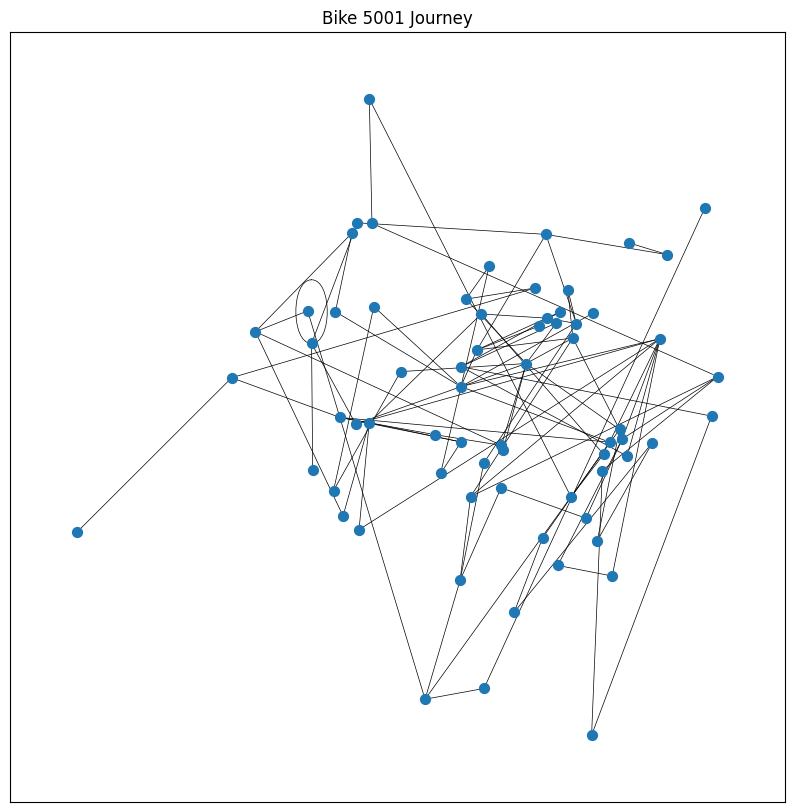

In [ ]:


bike5001_network = pd.read_sql("SELECT * FROM bike_5001 ORDER BY starttime LIMIT 100", con)


'''
G = nx.from_pandas_edgelist(question8, 'start_station_name', 'end_station_name', create_using=nx.Graph())  # undirected, unweighted graph
# Create figure
plt.figure(figsize=(15,15), dpi=100)
plt.title("Bike 5001 Journey.")
nx.draw_networkx(G, labels="", node_size=5) #node_color=node_colors, labels=nx_labels, node_size=50, font_size=15)
plt.show()

'''

G = nx.Graph()

#for row in bike5001_network.itertuples(index=False):
for index, row in bike5001_network.iterrows():
  ###G.add_node(row.start_station_name, pos=(row.start_station_longitude, row.start_station_latitude))
  # Add the nodes to the graph
  G.add_node(row.start_station_name, pos=(row.start_station_longitude, row.start_station_latitude))
  G.add_node(row.end_station_name, pos=(row.end_station_longitude, row.end_station_latitude))

  # Add the edge between start_station and end_station
  G.add_edge(row.start_station_name, row.end_station_name)


# Extract the node positions from the graph
node_positions = {node: node_data['pos'] for node, node_data in G.nodes(data=True)}

# Draw the graph
plt.figure(figsize=(10,10), dpi=100)
plt.title("Bike 5001 Journey")


# Change node colors to differentiate genes and diseases
edge_colors = range(100)

nx.draw_networkx(G, pos=node_positions, with_labels=False, arrows=True, node_size=50,
                 width=0.5, font_size=8)#,
                 #edge_cmap = plt.cm.Blues,
                 #edge_color = edge_colors)


plt.show()





#nx.draw(G, nx.get_node_attributes(G, 'pos'),
#        with_labels=False,
#        node_size=20,
#        node_color=range(274),
#        cmap=plt.cm.Blues)


#G2 = nx.from_pandas_edgelist(bike5001_network, 'start_station_name', 'end_station_name', create_using=nx.Graph())
#nx.draw_networkx(G2, labels="", node_size=5) #node_color=node_colors, labels=nx_labels, node_size=50, font_size=15)




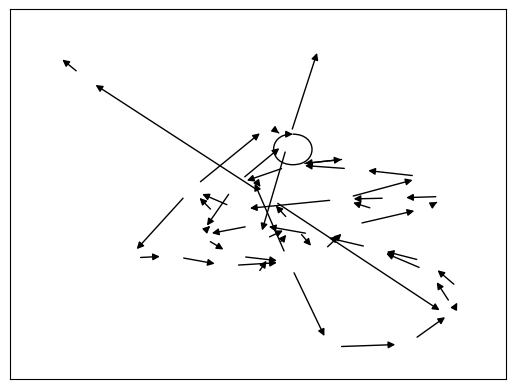

In [ ]:
G = nx.DiGraph()

#G.add_edges_from([(1, 2), (1, 3), (2, 3)])

for index, row in bike5001_network.iterrows():
  # Add the edge between start_station and end_station
  G.add_edge(row.start_station_name, row.end_station_name)


arcs = nx.draw_networkx_edges(G, pos=nx.spring_layout(G))